# Load modules 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy.interpolate import *
from scipy.integrate import quad
from cosmoslik import *

# Constants 

In [2]:
c=2.998e8 #speed of light (m/s)
rfid=147.78

# Load chains 

In [3]:
def derived_params(chain):
    chain['rs'] = c*10**-5/chain['H0']/chain['alphaBAO']
    chain['lsn'] = c*10**-7/chain['H0']/chain['alphaSN']
    chain['M'] = -5*np.log10(chain['lsn'])-19
    return chain
lcdm_chain = derived_params(chains.load_chain('LBAOSN.chain').burnin(5000).join())
npar_chain = derived_params(chains.load_chain('LBAOSNnonpar.chain').burnin(5000).join())

# Create Class for calculating D(z) under LCDM

In [4]:
class LCDM_D_z(object):
    def __init__(self):
        k=8.62*10**(-5) #Boltzmann constant (eV/K)
        Tg=2.73 #CMB photon temperature (K)
        h=0.72 #hubble
        self.mn=0.02/(c**2) #neutrino mass (eV/c^2)
        self.hp=4.136*10**(-15) #Planck constant (eV*s)
        self.L = self.mn*c**2/(k*Tg*(4/11)**(1/3))
        self.p0=1.88*h**2*10**(-26)*1.783*10**36 #current critical energy density
        zgrid4_omega_n=np.arange(.01,1,.01)
        omega_ngrid=np.array([self.omega_n(z) for z in zgrid4_omega_n])
        self.omega_n_z=sp.interpolate.CubicSpline(zgrid4_omega_n,omega_ngrid)
        self.omega_m=lcdm_chain.best_fit()['wm']
        self.omega_r=5*10**(-5)
        
    def omega_n(self,z):
        n_integrand = lambda x,z: x**2*np.sqrt((1/(1+z))**2+x**2)/(np.exp(x*self.L)+1)
        n=quad(n_integrand,0,np.inf,args=(z))
        return n[0]*((3*c**5*self.mn**4)*(1/(1+z))**(-4)*self.p0**(-1)*(np.pi)**(-2)*self.hp**(-3))
    
    def H0_over_H(self,z): 
        wm=self.omega_m
        wr=self.omega_r
        wn=self.omega_n_z
        return 1/(np.sqrt(wm*(1+z)**3+(1-wm-wr-wn(z))+wr*(1+z)**4+wn(z)))
    
    def __call__(self,z):
        rs=lcdm_chain.best_fit()['rs']
        alphaBAO = lcdm_chain.best_fit()['alphaBAO']
        return quad(self.H0_over_H,0,z)[0]*alphaBAO*100*rs

# Initialize Class to get function for calculating angular diameter distance DA_z 

In [5]:
DA_z = LCDM_D_z()


/nfs/home/kmaylor/.virtualenvs/Planck_and_SPTSZ_combo/lib/python3.4/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in exp


# LCDM model of D(z) (blue curve in fig 1) 

In [6]:
# zgrid and Dgrid are used later
zgrid0=np.arange(0,.1,.001)
zgrid1=np.arange(.1,3,.1)
zgrid2=np.arange(4,1100,1)
zgrid=list(zgrid0)+list(zgrid1)+list(zgrid2)

D_LCDMmodel=np.array([DA_z(z) for z in zgrid])



# BAO data, lcdm model, and residuals 

In [7]:
# D and z from BAO
zBAO=np.array([0.38,0.51,0.61])
DzBAO_data=np.array([1512.39,1975.22,2306.68])*npar_chain.best_fit()['rs']/rfid

#use lcdm model to get D(z) for same values as BAO
DzBAO_LCDMmodel=np.array([DA_z(z) for z in zBAO])

#residuals for BAO and lcdm D(z)
BAO_LCDMresiduals=DzBAO_data/DzBAO_LCDMmodel-1

# BAO errors 

In [8]:
BAO_dM_Hz_cov=np.loadtxt("BAO_consensus_covtot_dM_Hz.txt")
BAO_dM_cov=BAO_dM_Hz_cov[0::2,0::2]
DzBAO_errors=np.sqrt(np.diag(BAO_dM_cov))*npar_chain.best_fit()['rs']/rfid


# Non parametric model of D(z) (orange curve in fig 1)

In [9]:
#nonparametric D(z)
zspline=[0,.2,.57,.8,1.3]
H0=npar_chain.best_fit()['H0']
Hz1=npar_chain.best_fit()['Hz1']
Hz2=npar_chain.best_fit()['Hz2']
Hz3=npar_chain.best_fit()['Hz3']
Hz4=npar_chain.best_fit()['Hz4']
#alphaBAOnon=npar_chain.best_fit()['alphaBAO']
alphaSNnon=npar_chain.best_fit()['alphaSN']*10000
lsn=npar_chain.best_fit()['lsn']
rs = npar_chain.best_fit()['rs']
M = npar_chain.best_fit()['M']

Hzspline=[1,Hz1/H0,Hz2/H0,Hz3/H0,Hz4/H0]
H_zspline=sp.interpolate.CubicSpline(zspline,Hzspline)

def integrandH(z,H_zspline):
    return 1/H_zspline(z)

Dz_nonpar_model=np.array([alphaSNnon*lsn*quad(integrandH,0,z,args=(H_zspline))[0] for z in zgrid])

#DzBAO_nonpar_model=np.array([alphaBAOnon*100*rs*quad(integrandH,0,z,args=(H_z))[0] for z in zdata])

#BAO_nonpar_residuals=DzBAO_data/DzBAO_nonpar_model-1

#DzSN_nonpar_model=np.array([alphaSNnon*lsn*quad(integrandH,0,z,args=(H_z))[0] for z in zSN])

#SNresidnonpar=DzSN_data/DzSN_nonpar_model-1




# SNe data, lcdm model, and residuals 

In [10]:
zSN=np.loadtxt("z_SN.txt")
mb=np.loadtxt('mb_SN.txt')
DzSN_data=(1+zSN)**(-1)*10**((mb-25-npar_chain.best_fit()['M'])/5) 
DzSN_LCDMmodel=np.array([DA_z(z) for z in zSN])
SN_LCDMresiduals=DzSN_data/DzSN_LCDMmodel-1

# SNe errors 

In [11]:
dmbdata=np.loadtxt("dmb_SN.txt")
Csys=np.loadtxt("SNe_Csys.txt").reshape((40,40))
Cstat=np.diag(dmbdata**2) #statistical covariance matrix for SN data
SNcovariance=Cstat+Csys
SNerrors=np.sqrt(np.diag(SNcovariance))
DzSN_errors=SNerrors*c/1000/H0/(alphaSNnon)/(1+zSN)/5*np.log(10)*10**((mb-25-M)/5)

In [12]:
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'viridis',
    'axes.grid': False,
    'savefig.dpi': 100000.,  # to adjust notebook inline plot size
    'axes.labelsize': 15, # fontsize for x and y labels (was 10)
    'axes.titlesize': 16,
    'font.size': 12, # was 10
    'legend.fontsize': 14, # was 10
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'text.usetex': True,
    #'figure.figsize': [3.39, 2.10],
    'figure.figsize': [6.39, 5.10],
    'font.family': 'serif',
}

plt.rcParams.update(params)



/nfs/home/kmaylor/.virtualenvs/Planck_and_SPTSZ_combo/lib/python3.4/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


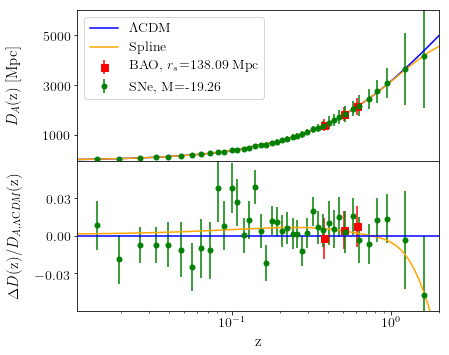

In [13]:
fig, (ax1, ax2) = plt.subplots(2,sharex=True)
ax1.plot(zgrid,D_LCDMmodel,label='$\Lambda$CDM',color='b')
ax1.plot(zgrid,Dz_nonpar_model,label='Spline',color='orange')
ax1.errorbar(zBAO,DzBAO_data,yerr=10*DzBAO_errors,label='BAO, $r_s$='+str(np.round(npar_chain.best_fit()['rs'],decimals=2))+' Mpc',fmt='sr',ms=7)
ax1.errorbar(zSN,DzSN_data,yerr=10*DzSN_errors,label='SNe, M='+str(np.round(npar_chain.best_fit()['M'],decimals=2)),fmt='og',ms=5)
ax1.set(ylim=(0,6000),yticks=[1000,3000,5000])
ax1.legend()
ax1.set(ylabel='$D_A(\mathrm z)$ [Mpc]')
ax1.yaxis.set_label_coords(-0.15,0.5)

ax2.errorbar(zBAO,BAO_LCDMresiduals,yerr=DzBAO_errors/DzBAO_LCDMmodel,fmt='sr',ms=7)
ax2.errorbar(zSN,SN_LCDMresiduals,yerr=DzSN_errors/DzSN_LCDMmodel,fmt='og',ms=5)

ax2.plot(zgrid,Dz_nonpar_model/D_LCDMmodel-1,color='orange')

ax2.axhline(y=0,color='b')
ax2.set(ylabel='$\Delta D(\mathrm z)/D_{A,\Lambda{\mathrm CDM}}(\mathrm z)$')
ax2.set(ylim=(-.06,.06),yticks=[-.03,0.00,.03])
ax2.set(xlim=(1.05e-2,2))
ax2.yaxis.set_label_coords(-0.15,0.5)
plt.xlabel('$\mathrm z$')
plt.xscale('log')
plt.tight_layout()
fig.subplots_adjust(hspace=0)
plt.show()
plt.savefig('D_z_lcdm_spline.pdf',pad_inches=.2)

# H(z) for LCDM and spline models 

In [14]:
zgrid4H=np.arange(0,1,0.0001)
Hvals_nonpar=np.array([H0*H_zspline(z) for z in zgrid4H])
HvalsLCDM=np.array([H0/DA_z.H0_over_H(z) for z in zgrid4H])
Hzdata=np.array([81.2087,90.9029,98.9647])*rfid/rs
hco=BAO_dM_Hz_cov[1::2,1::2]
Herrors=np.sqrt(np.diag(hco))
Hguess=np.array([H_zspline(x) for x in 1/(1+zBAO)])
Hresiduals=Hzdata/Hguess-1

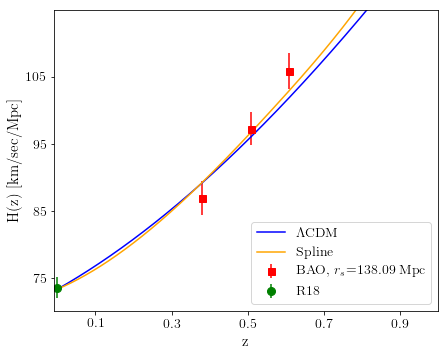

In [23]:
fig, axes = plt.subplots(1,sharex=True)#,sharey=True)
axes.plot(zgrid4H,HvalsLCDM,label='$\Lambda$CDM',color='b')
axes.plot(zgrid4H,Hvals_nonpar,label='Spline',color='orange')
axes.errorbar(zBAO,Hzdata,yerr=Herrors*rfid/rs,marker='s',ms=7,fmt='sr',label='BAO, $r_s$='+str(np.round(npar_chain.best_fit()['rs'],decimals=2))+' Mpc')
axes.errorbar(0,73.52,yerr=1.62,fmt='og',label='R18',ms=8)
axes.legend(loc=4)
axes.set_ylabel('H(z) [km/sec/Mpc]')
axes.set_xlabel('z',size=15)
axes.set_xlim((-0.01,1))
axes.set_ylim((70,115))
axes.set_xticks(np.arange(.1,1,.2))
axes.set_yticks(range(75,115,10))
fig.tight_layout()
plt.show()
fig.savefig('H_z_lcdm_spline.pdf',pad_inches=.2)